# Example Workflow

Introduction to the processing steps of the mesh refinement workflow.

For details motivating each of these processing steps, see our publication in JAMES or on EarthArXiv.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import unstructured_mesh_refinement_tools as umrm

Text(0.5, 1.0, 'Unprocessed Input Mask')

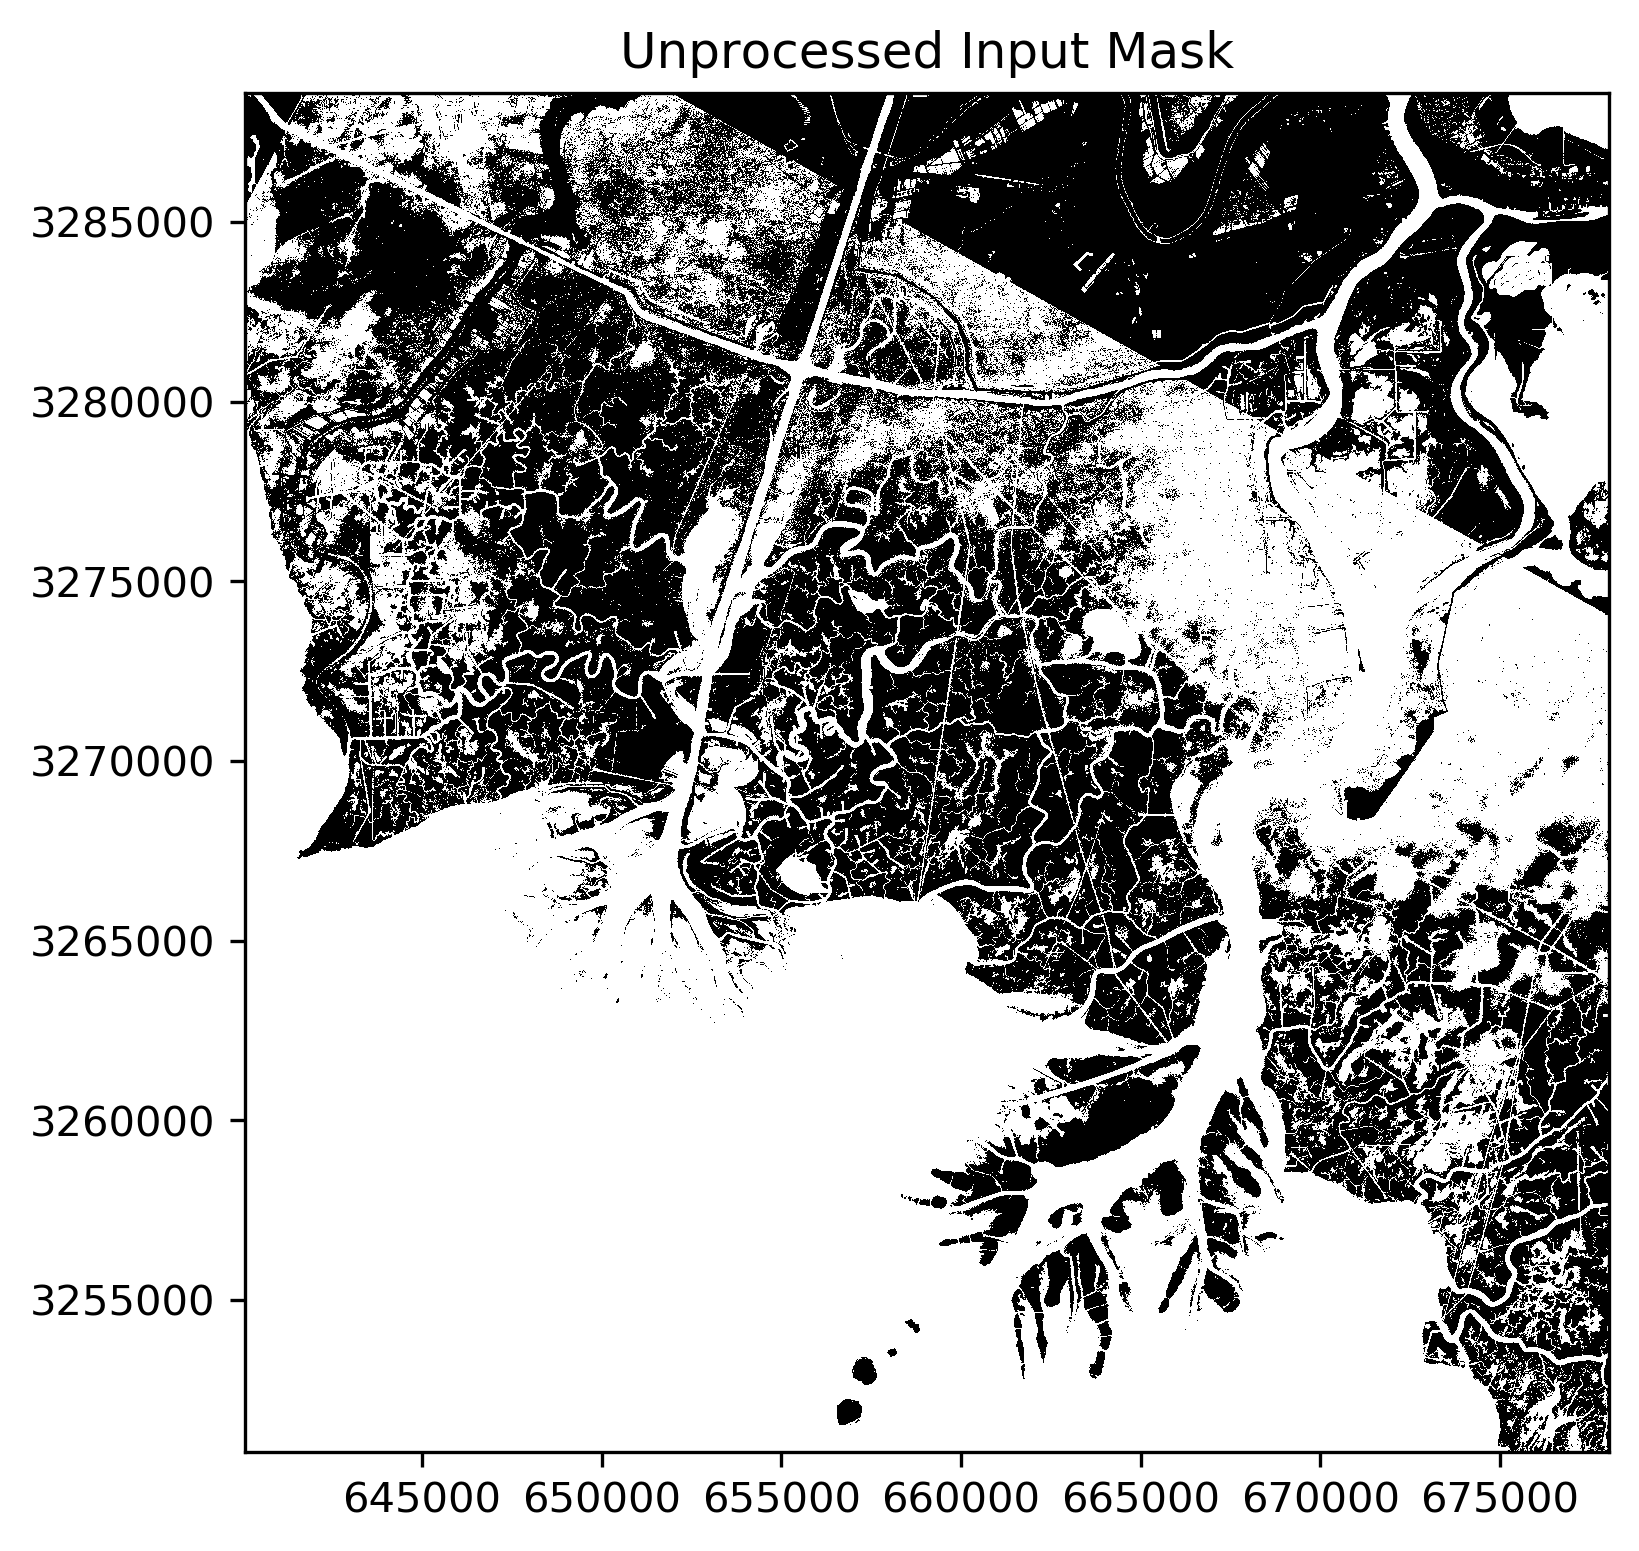

In [2]:
# ANUGA Model Boundary:
bounds = np.loadtxt(os.path.join('example_data','Boundary_WLAD.csv'), delimiter=',')
# File path to binary image:
image_file = os.path.join('example_data','InputMask_WLAD.tif')
# Grid size in meters:
dx = 5
# Buffer size between objects in pixels:
buffer = 10
# Epsilon for RDP algorithm in meters:
epsilon = 50

# Load image
src = rasterio.open(image_file)
extent = [src.bounds[0], src.bounds[2],
          src.bounds[1], src.bounds[3]]
image = src.read(1)

fig = plt.figure(figsize=(6, 6), dpi=300)
plt.imshow(image, extent=extent, cmap='gist_gray')
plt.title('Unprocessed Input Mask')

Text(0.5, 1.0, 'Model Boundary')

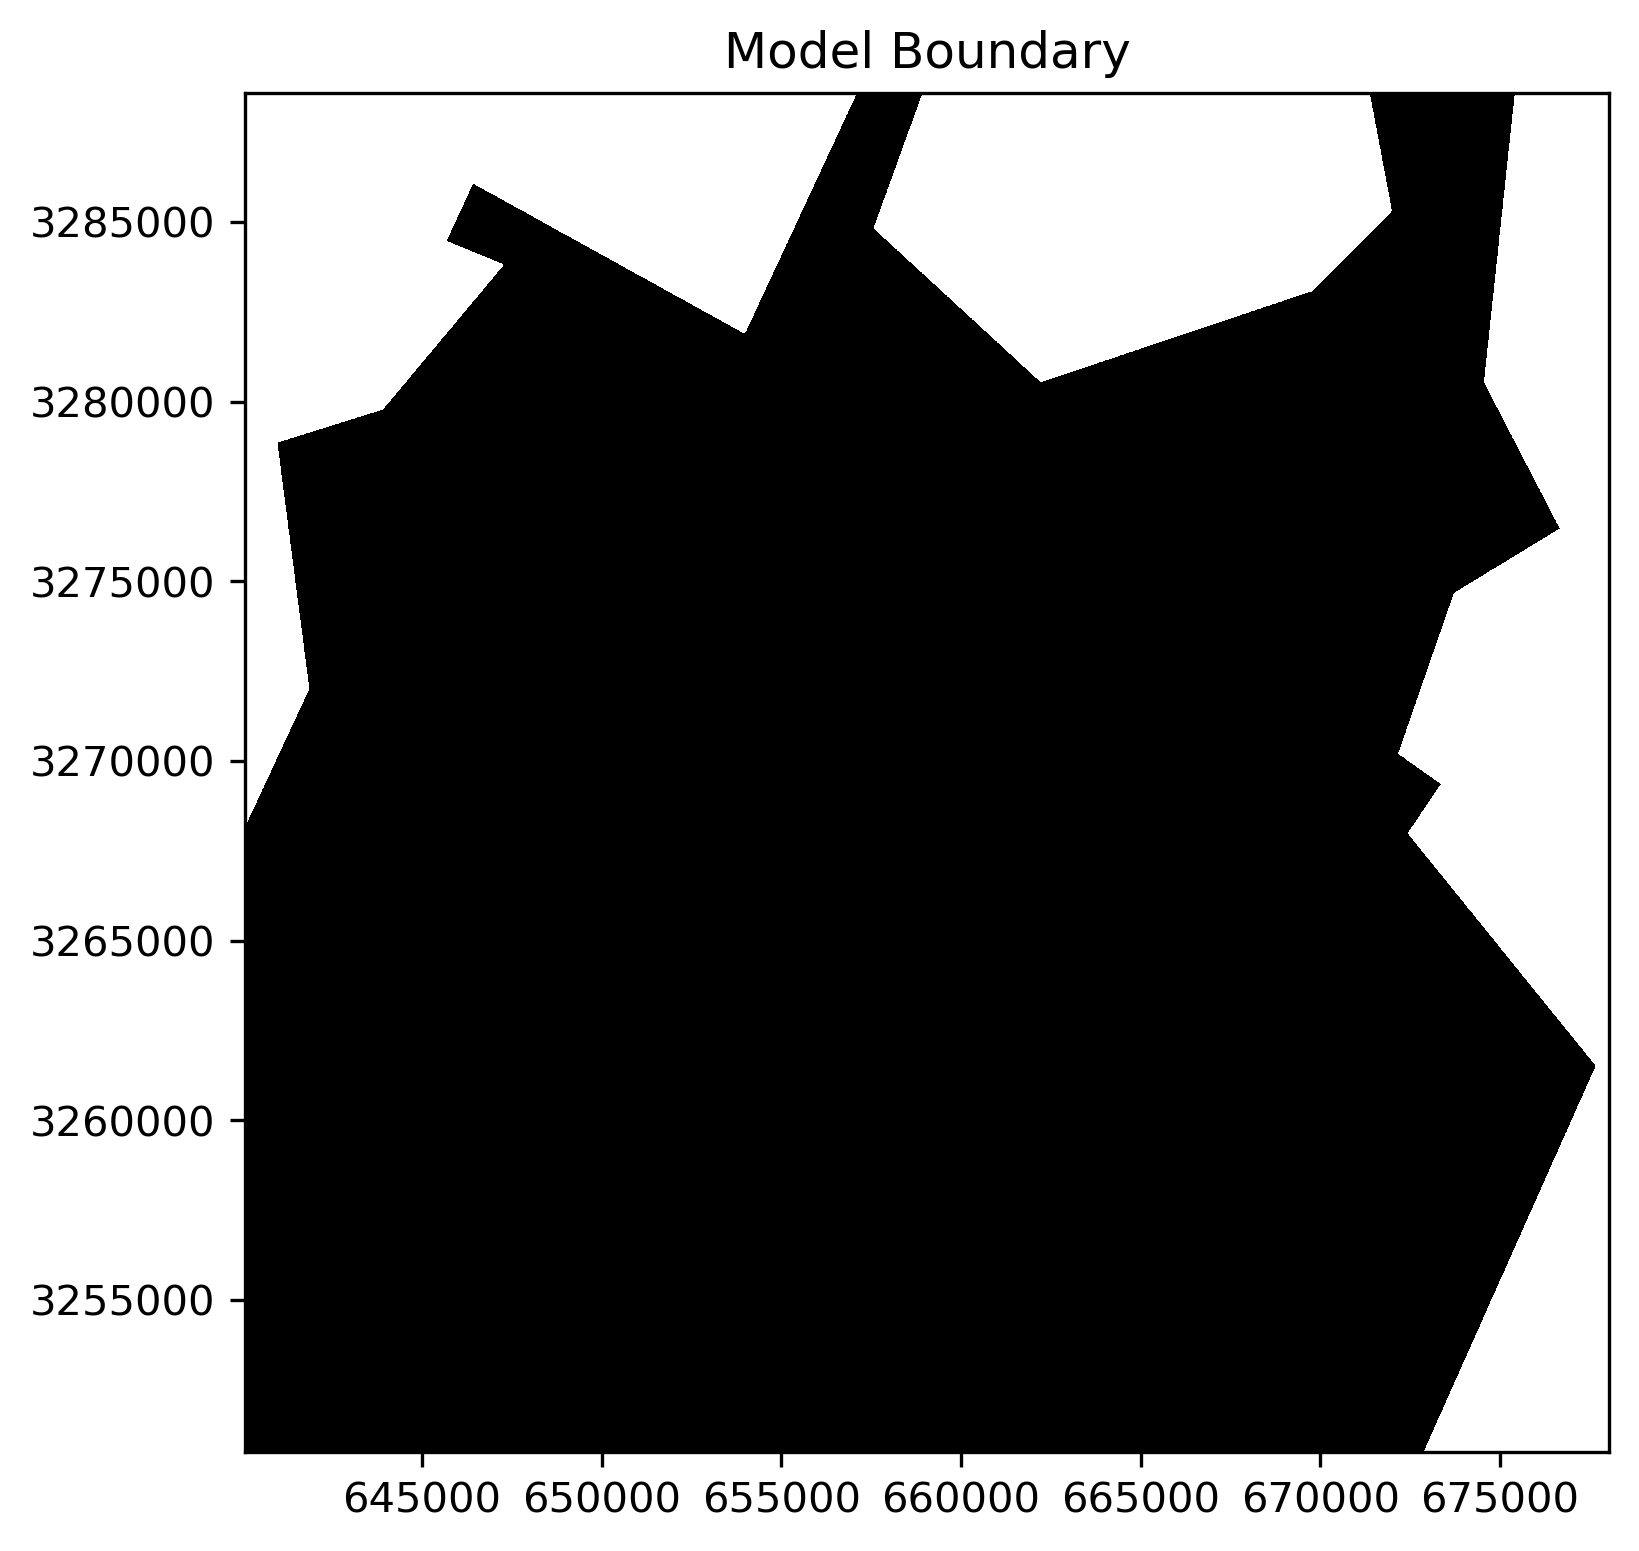

In [3]:
outside = umrm.generate_boundary(bounds, dx, extent, one_sided_buffer)

fig = plt.figure(figsize=(6, 6), dpi=300)
plt.imshow(outside, extent=extent, cmap='gist_gray')
plt.title('Model Boundary')

Text(0.5, 1.0, 'After Connectivity Filter')

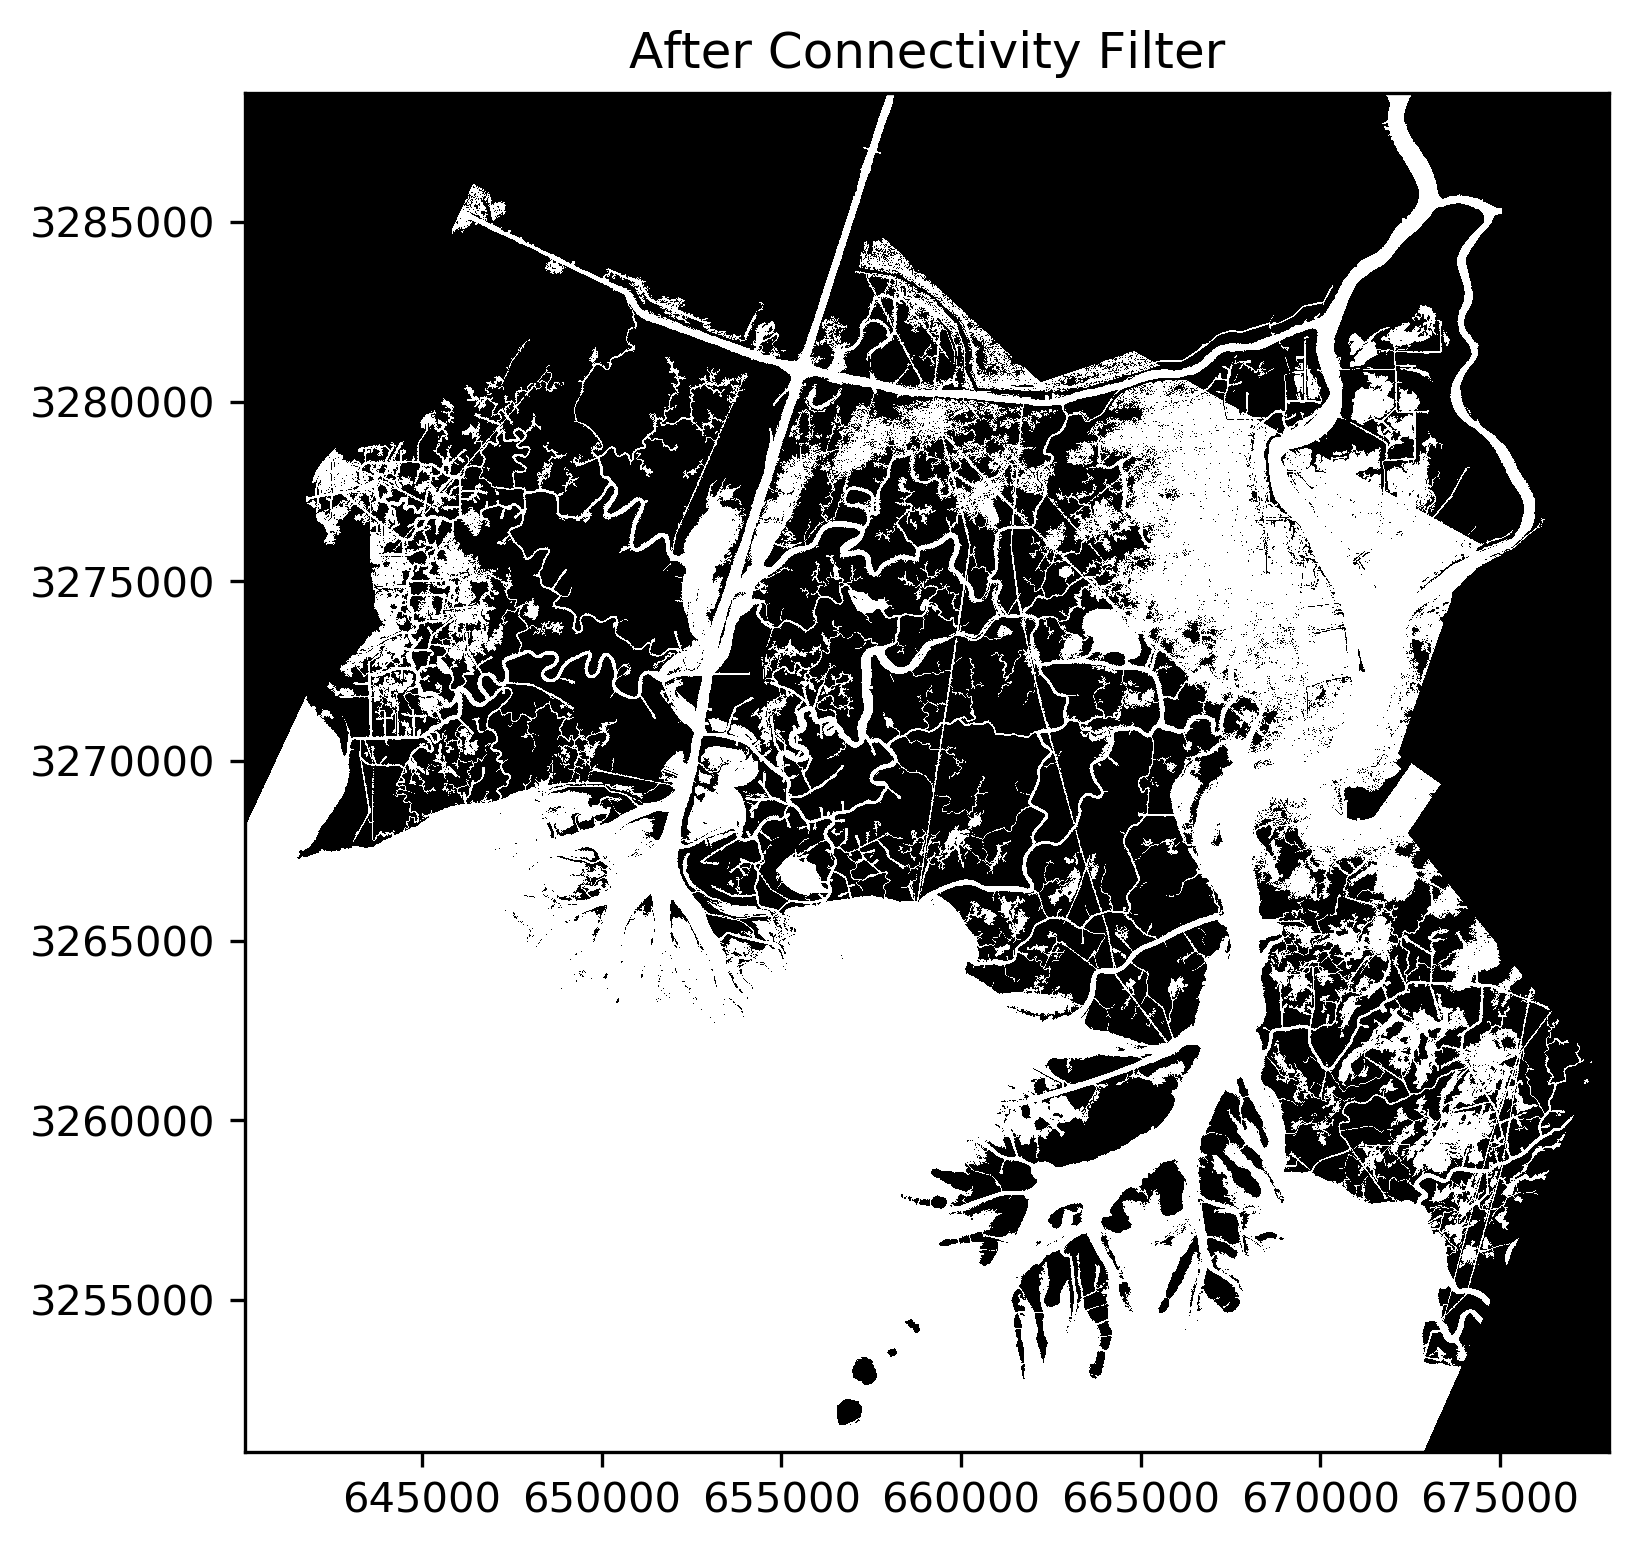

In [4]:
connected_cluster = umrm.enforce_connectivity(image, outside)

fig = plt.figure(figsize=(6, 6), dpi=300)
plt.imshow(connected_cluster, extent=extent, cmap='gist_gray')
plt.title('After Connectivity Filter')

Text(0.5, 1.0, 'After Dilation')

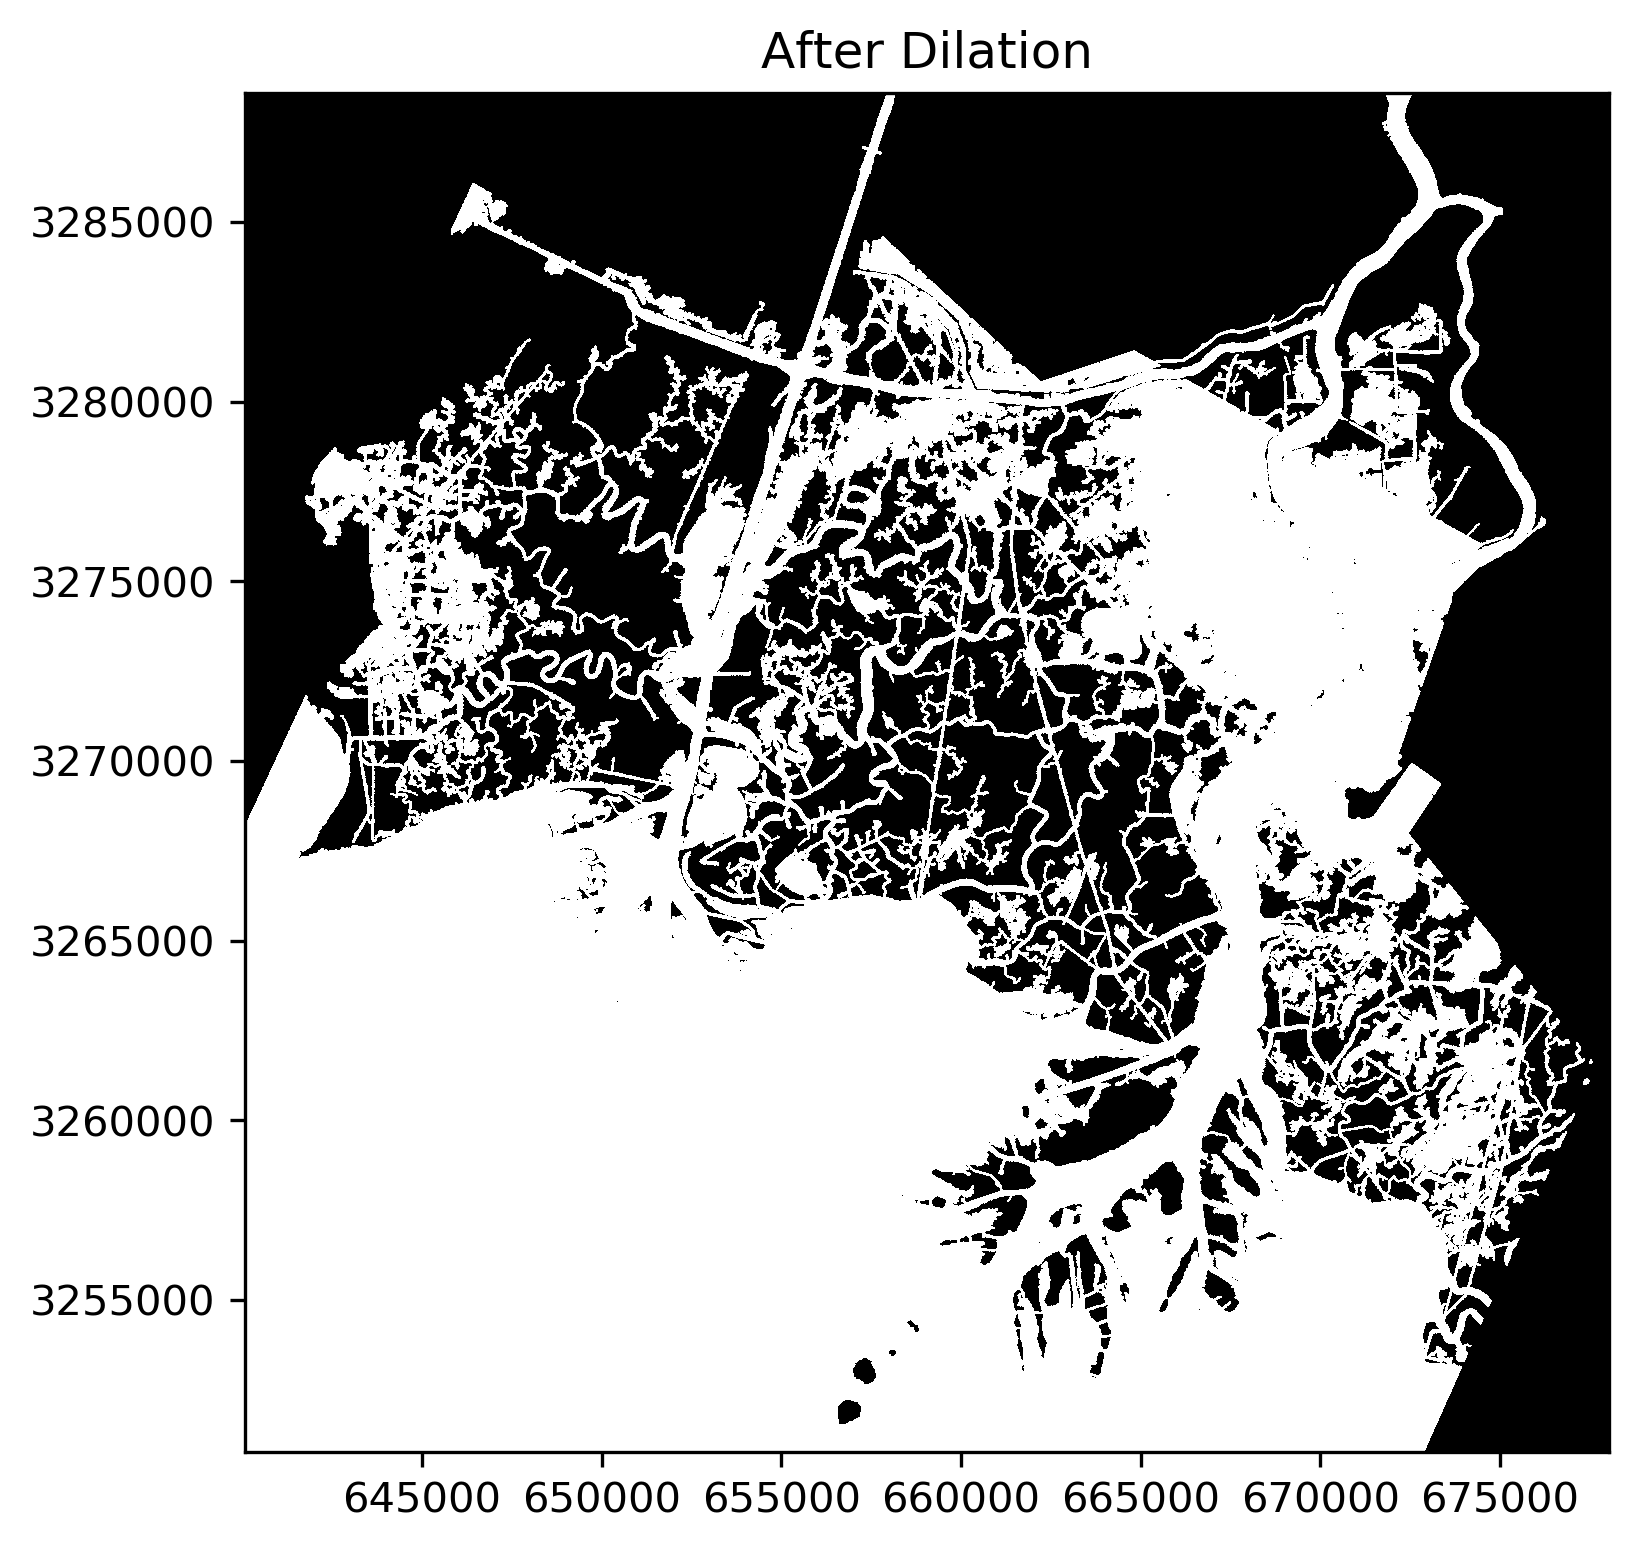

In [5]:
# The buffer here acts in two directions, so the buffer dimension should be half that of the other functions
dilated_cluster = umrm.ensure_minimum_width(connected_cluster, buffer/2)

fig = plt.figure(figsize=(6, 6), dpi=300)
plt.imshow(dilated_cluster, extent=extent, cmap='gist_gray')
plt.title('After Dilation')

Text(0.5, 1.0, 'After Smoothing')

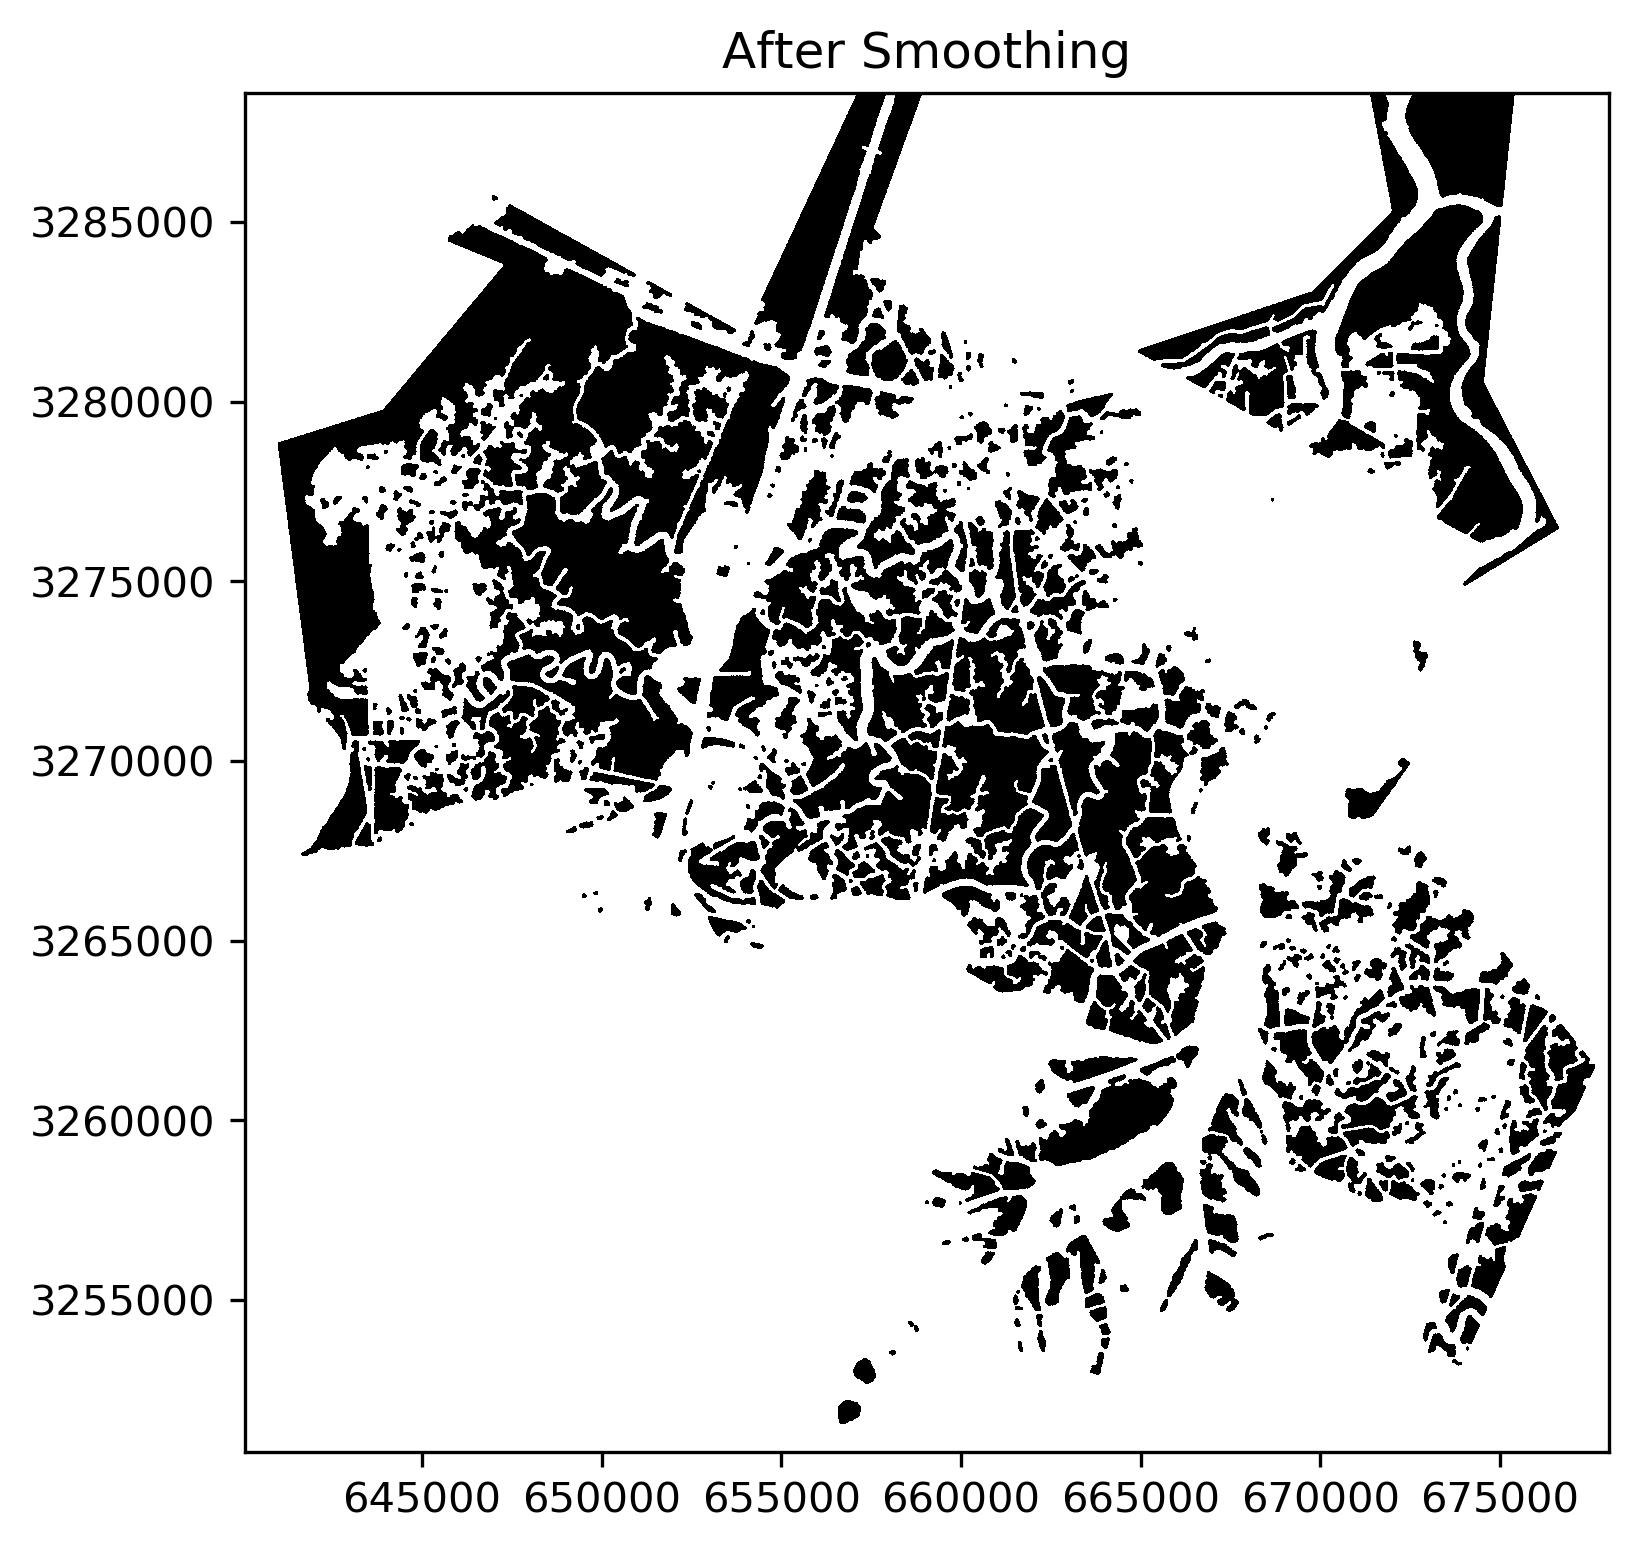

In [6]:
smoothed_cluster = umrm.smooth_object_interface(dilated_cluster, outside, one_sided_buffer)

fig = plt.figure(figsize=(6, 6), dpi=300)
plt.imshow(smoothed_cluster, extent=extent, cmap='gist_gray')
plt.title('After Smoothing')

Text(0.5, 1.0, 'After Removing Small Islands')

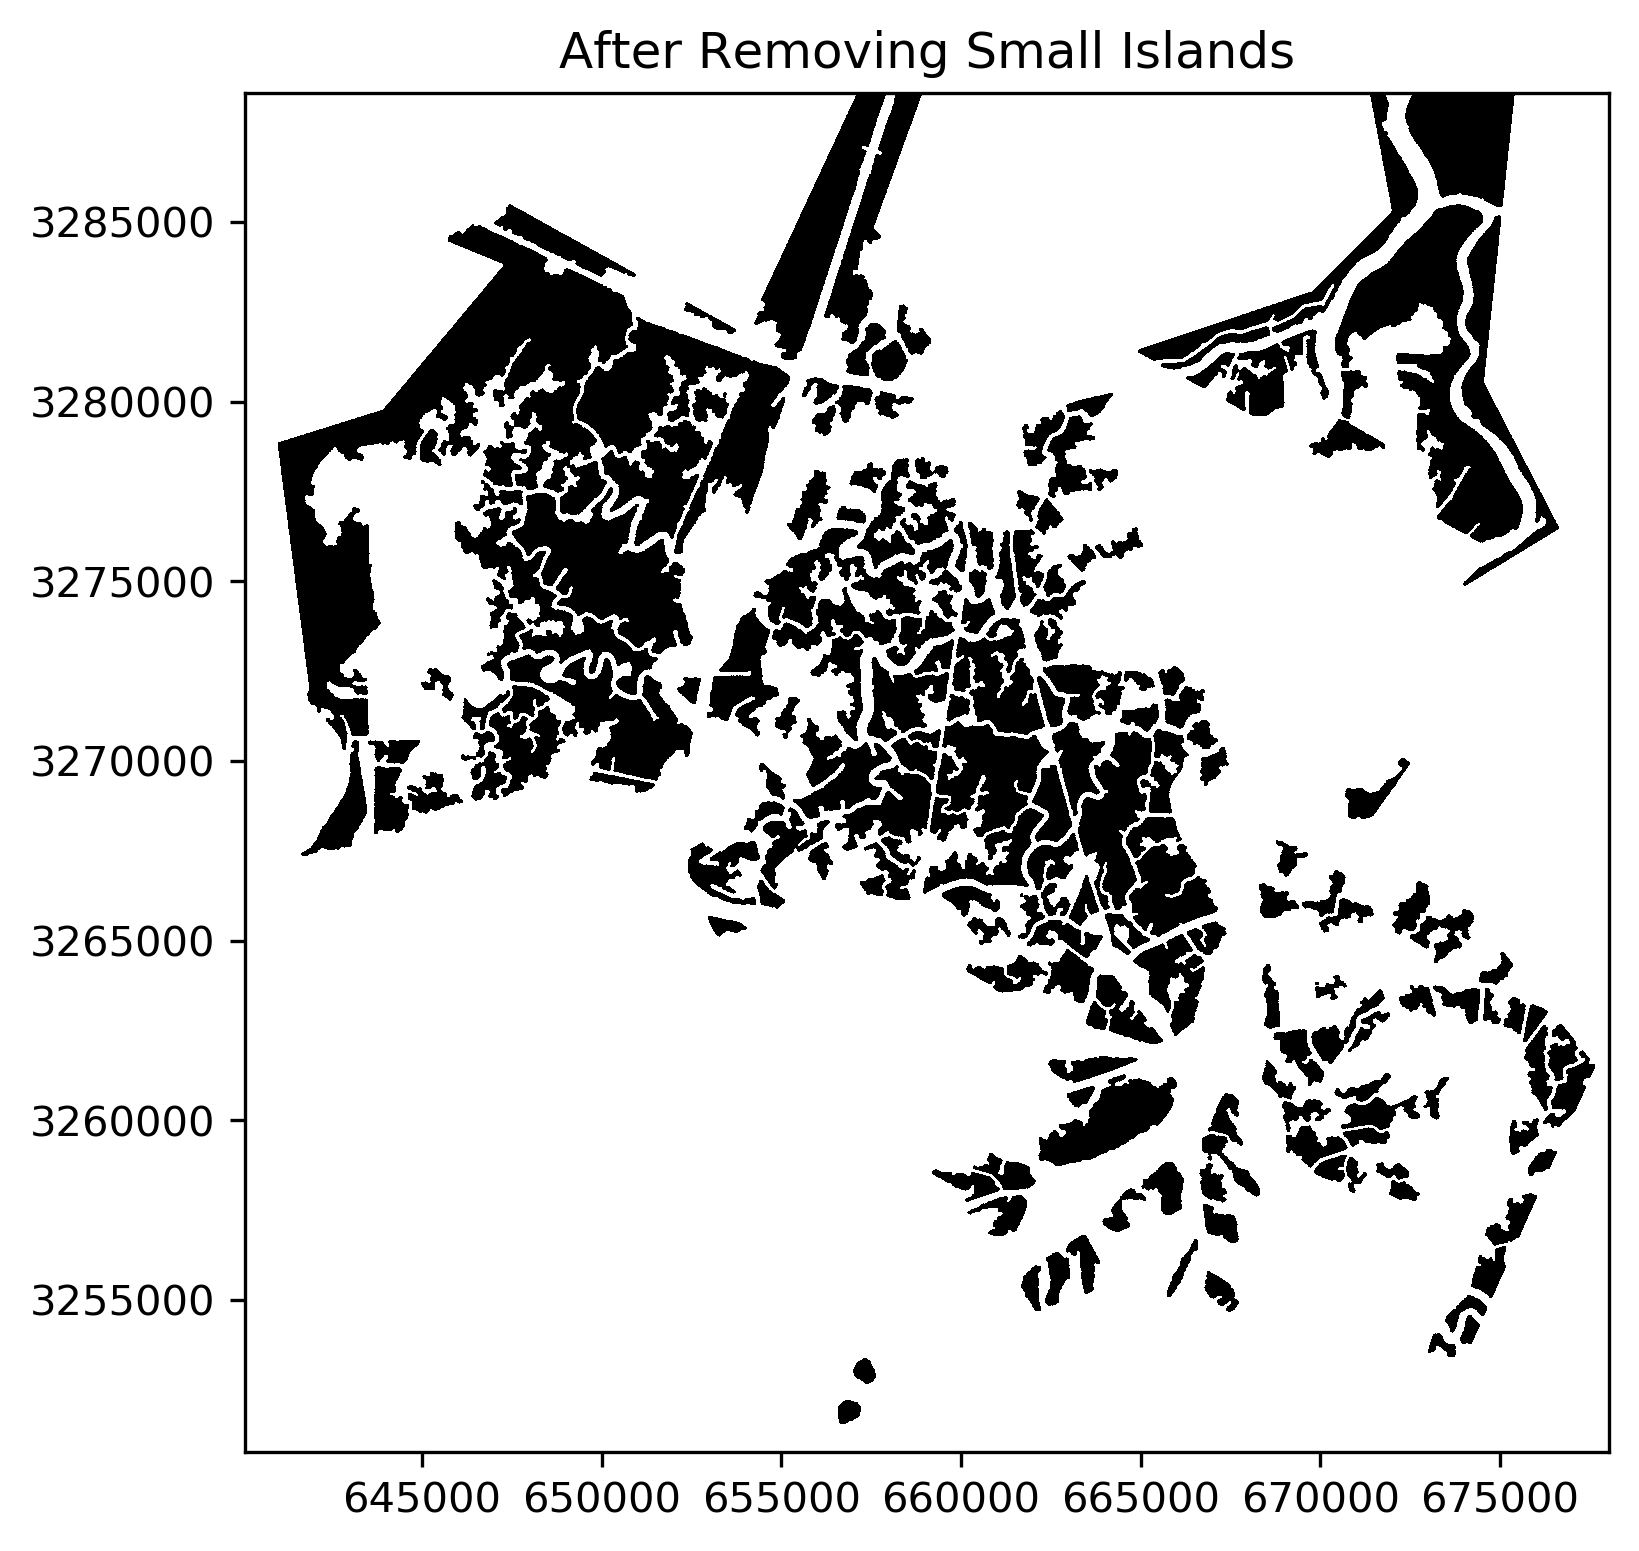

In [15]:
# Set minimum island size to at least 500m x 500m in area
min_size = 500**2/dx**2
large_islands = umrm.ensure_large_islands(smoothed_cluster, min_size)

fig = plt.figure(figsize=(6, 6), dpi=300)
plt.imshow(large_islands, extent=extent, cmap='gist_gray')
plt.title('After Removing Small Islands')

In [16]:
# This function is optional, but we find that it improves the output of the RDP results later.
large_islands = umrm.smooth_island_interface(large_islands, outside)

# Plotting turned off because differences caused by this function are nearly imperceptible.
# fig = plt.figure(figsize=(6, 6), dpi=300)
# plt.imshow(large_islands, extent=extent, cmap='gist_gray')
# plt.title('After Smoothing Islands')

Text(0.5, 1.0, 'Converted to Polygons')

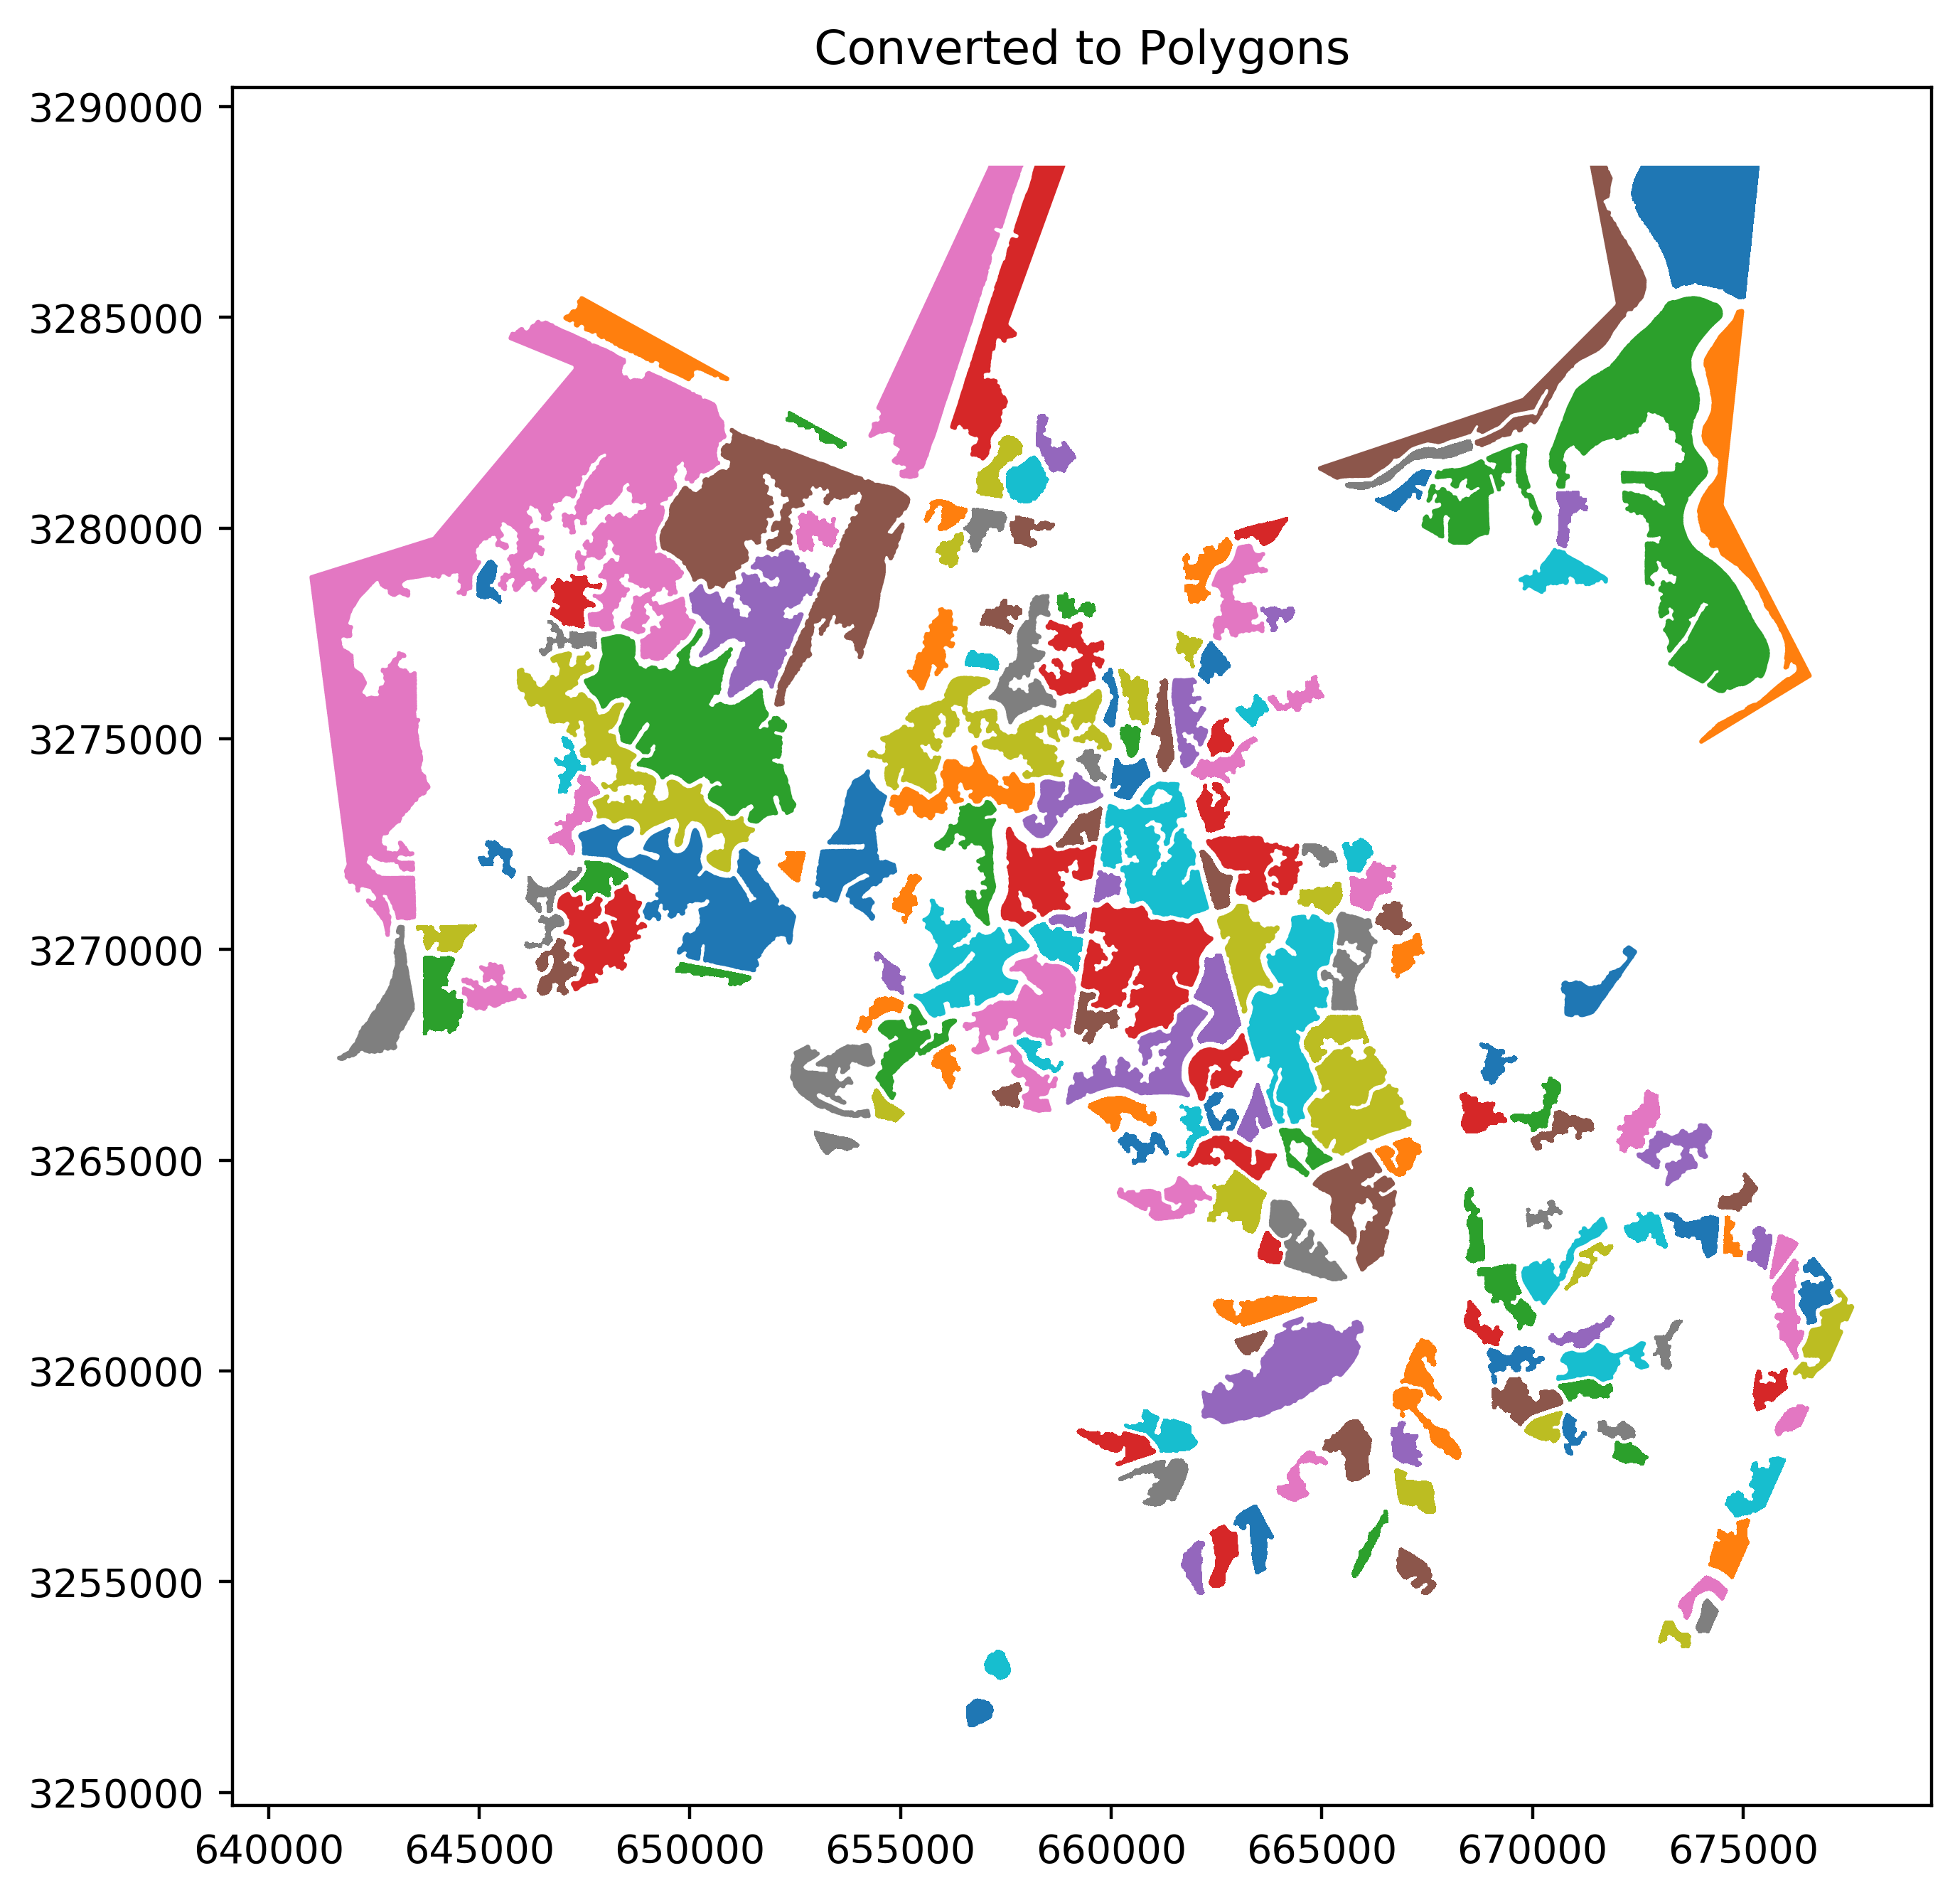

In [17]:
polycoords = umrm.raster2polygon(large_islands, image_file)

umrm.plot_polygons(polycoords)
plt.title('Converted to Polygons')

Text(0.5, 1.0, 'After RDP Simplification')

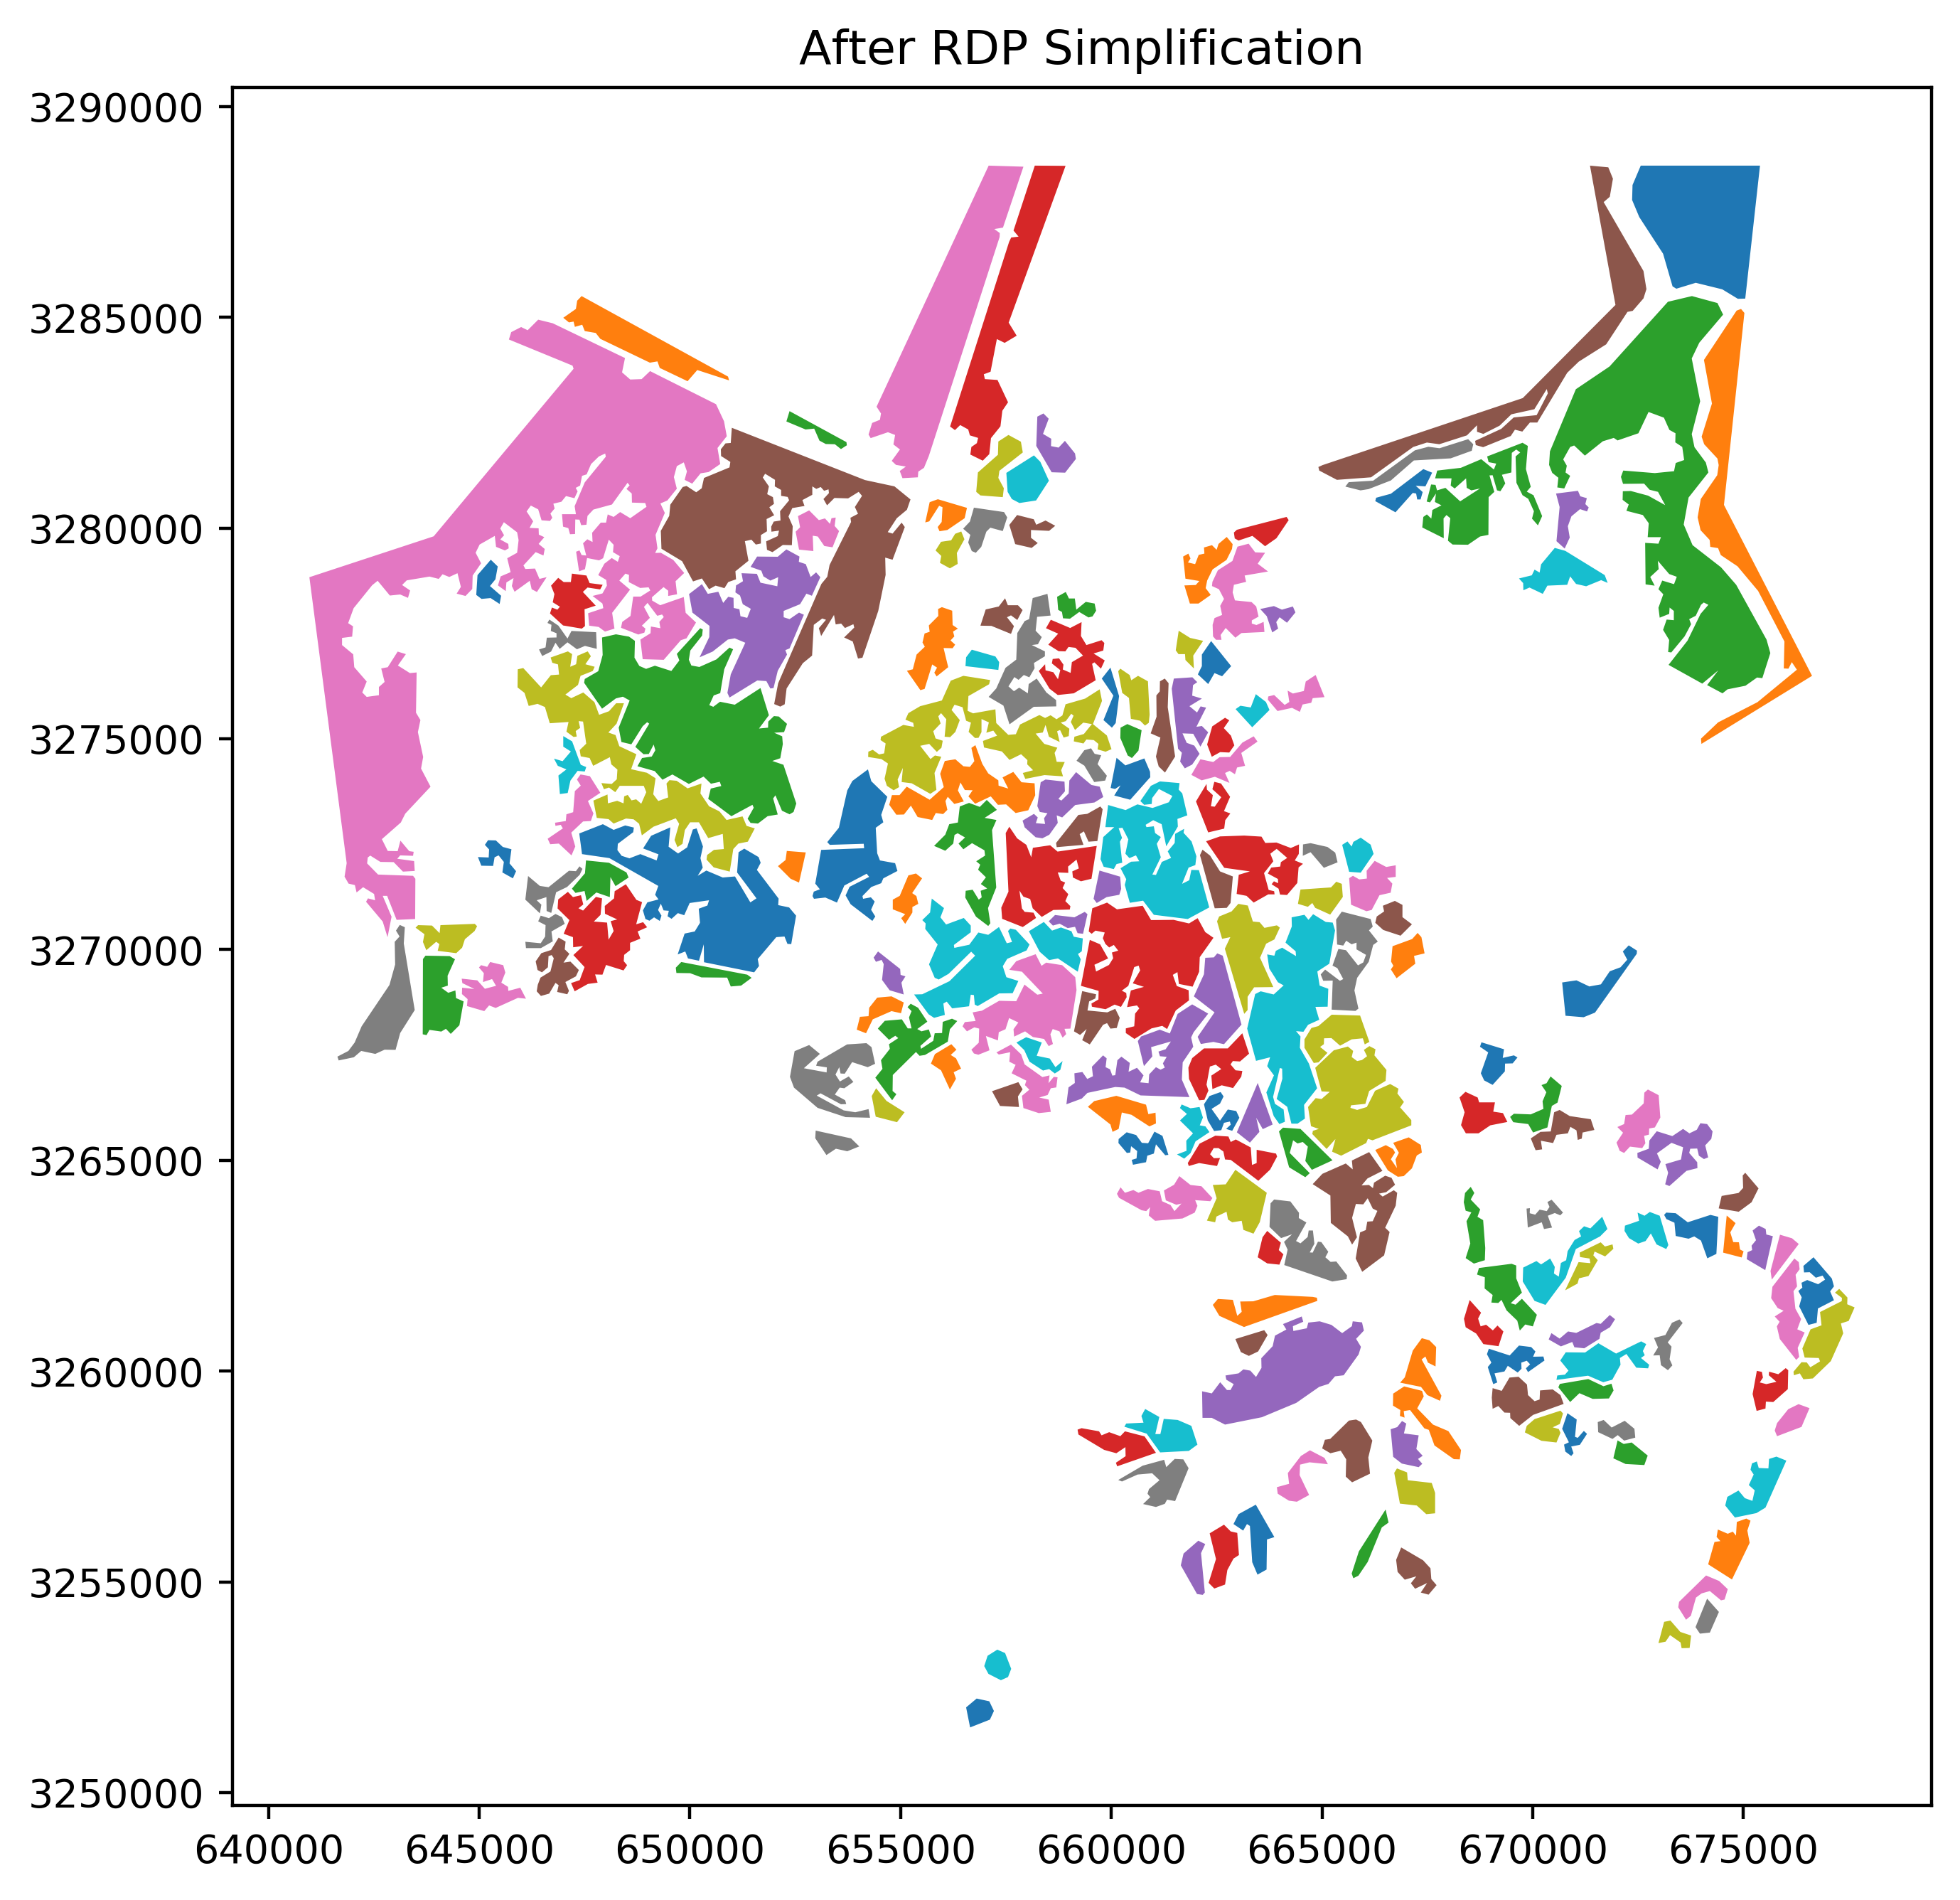

In [18]:
simple_polygons = umrm.simplify_polygons(polycoords, epsilon)

umrm.plot_polygons(simple_polygons)
plt.title('After RDP Simplification')

Text(0.5, 1.0, 'Sharp Angles Removed')

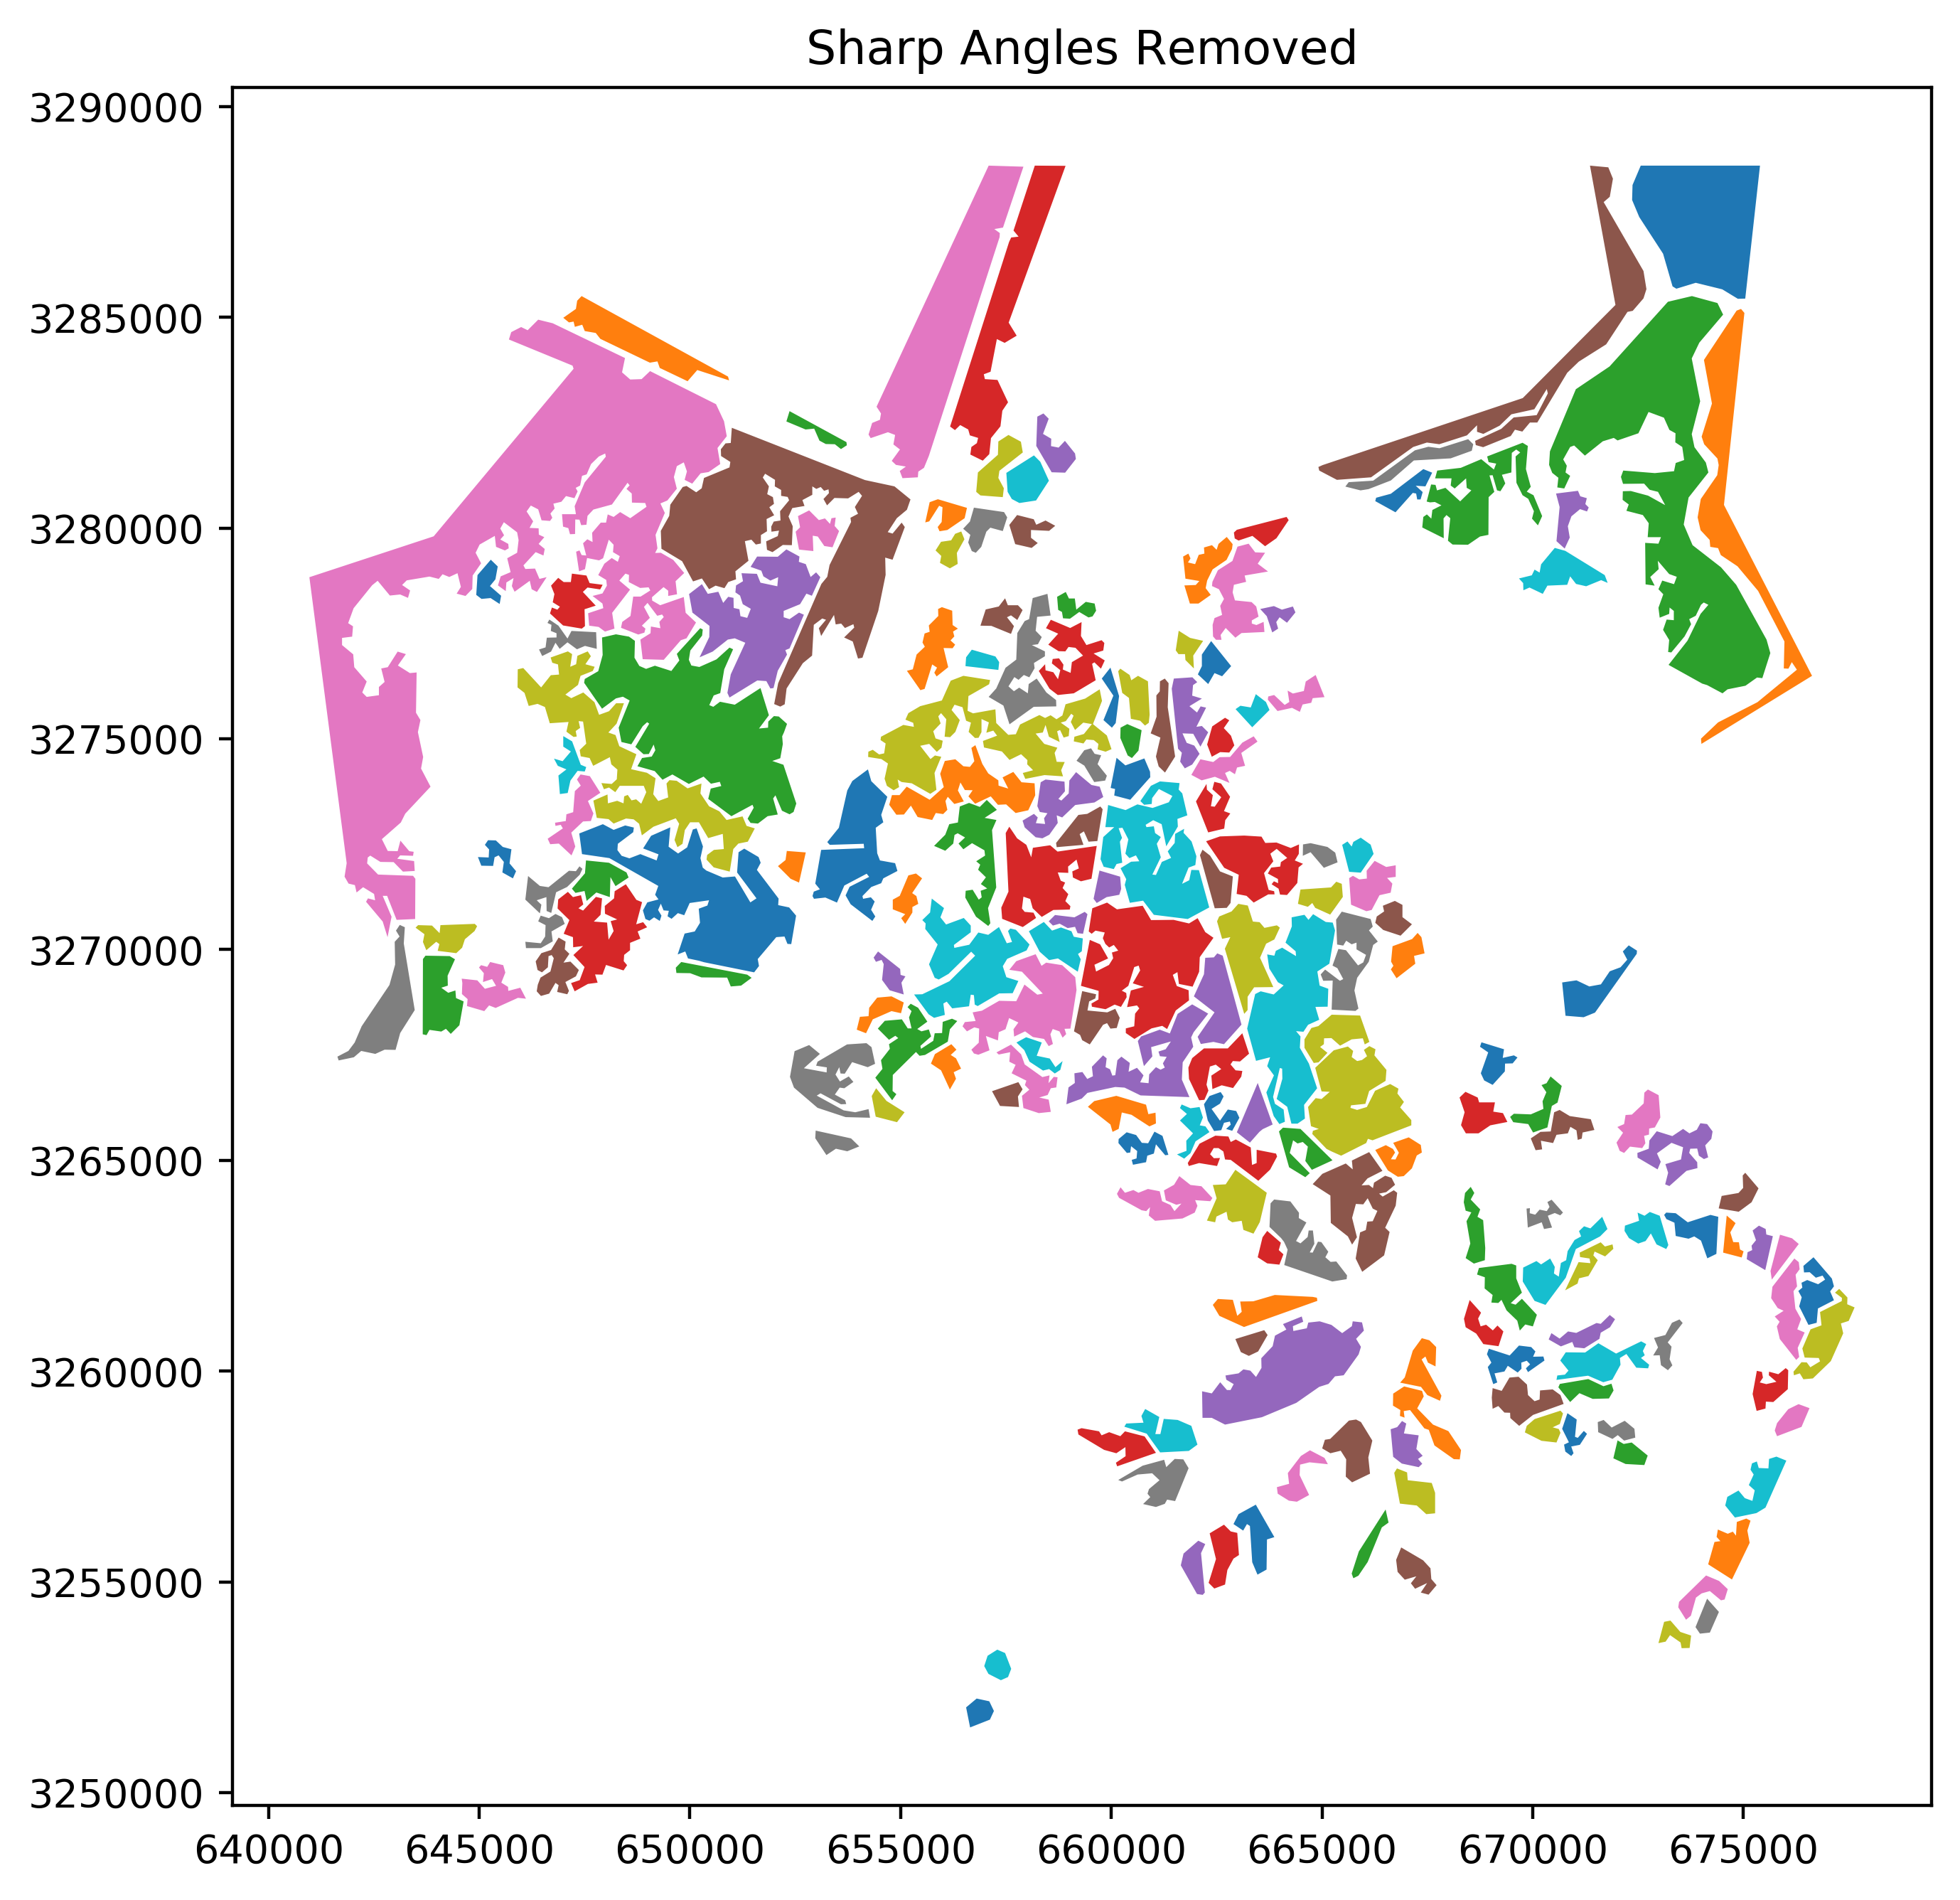

In [19]:
safe_simple_polygons = umrm.filter_poly_angles(simple_polygons)

umrm.plot_polygons(safe_simple_polygons)
plt.title('Sharp Angles Removed')

In [21]:
triangle_res = 62500 # Max triangle resolution
umrm.save_for_anuga(safe_simple_polygons, 'example_data', triangle_res)

After running `save_for_anuga` you should find the full list of 180 polygon files in the 'example data' folder. These polygons are compatible with and ready to be imported into ANUGA.

Here's an example code snippet for loading these back in to use with ANUGA mesh generation:

```
polygon_files = glob.glob('outfolder/*Reg*.csv')
inside_regions = []
for poly in polygon_files:
    polyres = int(poly.split('_Res')[-1].replace('.csv',''))
    inside_regions.append([anuga.read_polygon(poly), polyres])
domain = anuga.create_domain_from_regions(..., interior_regions=inside_regions)
```